In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VAE for genetic circuits

In this notebook, we will follow RaptGen more closely ([Generative aptamer discovery using RaptGen](https://www.nature.com/articles/s43588-022-00249-6#Fig1)) and implement a the VAE encoder. See the [VAE class](https://github.com/hmdlab/raptgen/blob/c4986ca9fa439b9389916c05829da4ff9c30d6f3/raptgen/models.py#L807) in the RaptGen repo.


## Imports

In [4]:
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform

from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score  
import os
import sys
import numpy as np
import haiku as hk
import jax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

[CpuDevice(id=0)]

In [5]:
from src.models.vae import VAE
from src.models.mlp import MLP
from src.models.shared import arrayise
from src.losses.losses import loss_fn, compute_accuracy_regression
from src.utils.data_preprocessing import drop_duplicates_keep_first_n
from src.utils.optimiser import make_optimiser
from src.utils.train import train

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


## Load Data

In [6]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

# Hyperparameters

In [7]:
# Architecture
HIDDEN_SIZE = 32
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3


BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
TRAIN_SPLIT = 0.8
SCALE_X = False
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 1000
SEED = 1
input_concat_axis = 0

USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = True

loss_fn = partial(
    loss_fn, loss_type='mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_regression

subtask = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + subtask
save_path = os.path.join('weight_saves', '09_vae', save_path)

rng = jax.random.PRNGKey(SEED)

# Initialise 

## Init data

In [8]:
filt = data['sample_name'] == data['sample_name'].unique()[0]

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
N_BATCHES = TOTAL_DS // BATCH_SIZE
TOTAL_DS = N_BATCHES * BATCH_SIZE

x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

y = x

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = x.shape[-1]


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [9]:
x.shape

(153600, 6)

In [10]:
if SCALE_X:
    xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
    x = xscaler.fit_transform(x)
    y = xscaler.transform(y)

## Init model

In [12]:
enc_layers = [64] * NUM_ENC_LAYERS
dec_layers = [64] * NUM_DEC_LAYERS

def VAE_fn(x: np.ndarray, enc_layers: list, dec_layers: list, call_kwargs: dict = {}):
    encoder = MLP(layer_sizes=enc_layers, n_head=dec_layers[0], use_categorical=False, name='encoder')
    decoder = MLP(layer_sizes=dec_layers, n_head=x.shape[-1], use_categorical=False, name='decoder')

    model = VAE(encoder=encoder, decoder=decoder, embed_size=HIDDEN_SIZE)
    return model(x, **call_kwargs)

model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers)
model = hk.transform(model_fn)
params = model.init(rng, x[:2])


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


## Init optimiser

In [13]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

In [14]:
optimiser_state

(EmptyState(), ScaleByScheduleState(count=Array(0, dtype=int32)))

# Train

In [ ]:
# [i_batch, xy, Batches, *content]
        
x = x.reshape(N_BATCHES, 1, BATCH_SIZE, x.shape[-1])
y = y.reshape(N_BATCHES, 1, BATCH_SIZE, y.shape[-1])

x_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]
xy_train = np.concatenate([x_train, y_train], axis=1)

In [25]:
params, saves = train(params, rng, model, xy_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=loss_fn,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

Epoch 0 / 100 -		 Train loss: 14.653785705566406	Val loss: 14.427469253540039	Val accuracy: 14.427469253540039
Epoch 10 / 100 -		 Train loss: 13.64722728729248	Val loss: 13.55930233001709	Val accuracy: 13.55930233001709
Epoch 20 / 100 -		 Train loss: 13.466217994689941	Val loss: 13.393377304077148	Val accuracy: 13.393377304077148
Epoch 30 / 100 -		 Train loss: 13.419185638427734	Val loss: 13.350049018859863	Val accuracy: 13.350049018859863
Epoch 40 / 100 -		 Train loss: 13.39565658569336	Val loss: 13.32848834991455	Val accuracy: 13.32848834991455
Epoch 50 / 100 -		 Train loss: 13.375405311584473	Val loss: 13.310099601745605	Val accuracy: 13.310099601745605
Epoch 60 / 100 -		 Train loss: 13.355058670043945	Val loss: 13.29146671295166	Val accuracy: 13.29146671295166
Epoch 70 / 100 -		 Train loss: 13.333891868591309	Val loss: 13.271986961364746	Val accuracy: 13.271986961364746
Epoch 80 / 100 -		 Train loss: 13.311235427856445	Val loss: 13.251020431518555	Val accuracy: 13.251020431518555
E

# Visualise

Text(0.5, 0, 'step')

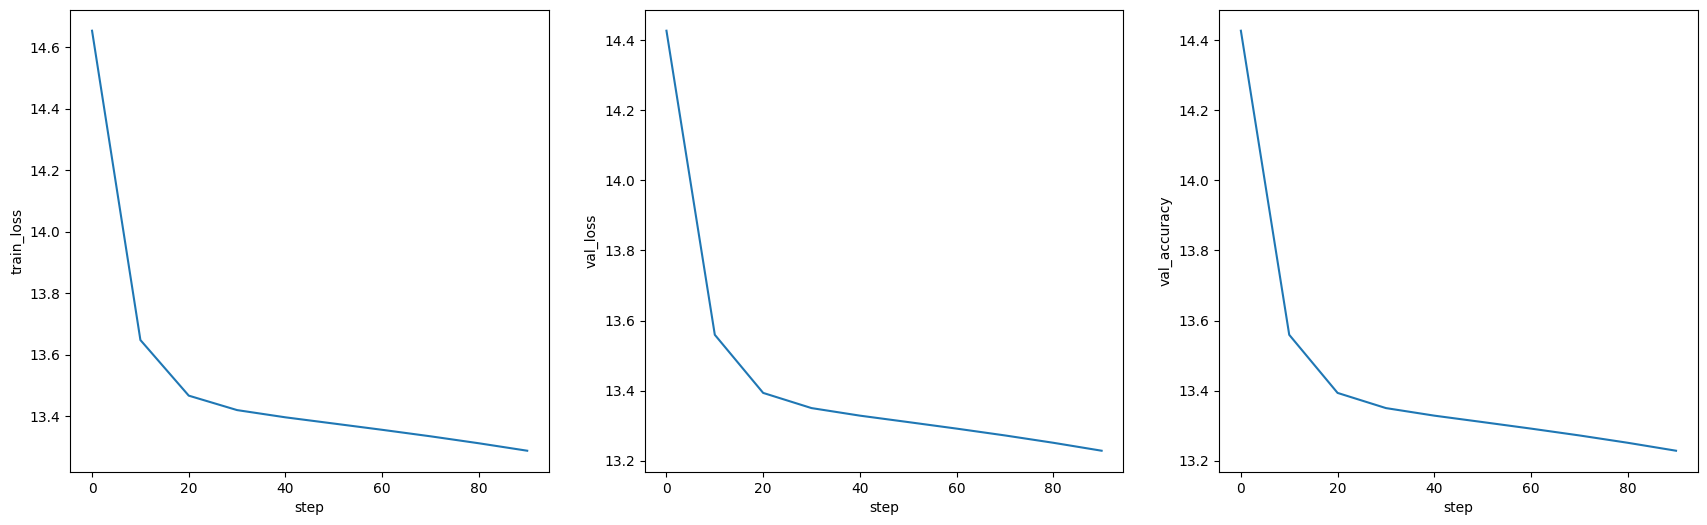

In [26]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

In [ ]:
write_json(saves, out_path=save_path)


## Examine trained model


In [13]:
for k1, k in zip(p.keys(), params.keys()):
    p[k] = p[k1]

dict_keys(['encoder/~create_layers/linear', 'encoder/~create_layers/linear_1', 'encoder/~create_layers/linear_2', 'encoder/~create_layers/linear_3', 'vae/~/h2mu', 'vae/~/h2logvar', 'decoder/~create_layers/linear', 'decoder/~create_layers/linear_1', 'decoder/~create_layers/linear_2', 'decoder/~create_layers/linear_3'])

In [22]:
fn_saves = os.path.join('weight_saves', '09_vae', '2023_12_12__18_12_10_saves_test')
# fn_saves = save_path
if not os.path.isfile(fn_saves):
    fn_saves = save_path
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
p['vae/~/h2mu'] = p.pop('vae/~/linear')
p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model.apply(p, rng, x, call_kwargs={'inference': True, 'logging': False, 'key': rng})
pred_y.shape

(1200, 1, 128, 6)

The R2 score is  0.9987095362308978
The R2 score with weighted variance is  0.9987095362308979


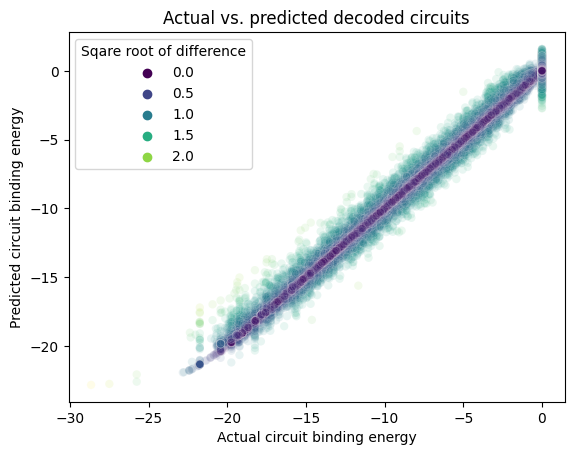

In [23]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')
# plt.legend(title='')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

In [61]:
params.keys()

dict_keys(['encoder/~create_layers/linear', 'encoder/~create_layers/linear_1', 'encoder/~create_layers/linear_2', 'encoder/~create_layers/linear_3', 'vae/~/linear', 'vae/~/linear_1', 'decoder/~create_layers/linear', 'decoder/~create_layers/linear_1', 'decoder/~create_layers/linear_2', 'decoder/~create_layers/linear_3'])

Text(0.5, 0, 'step')

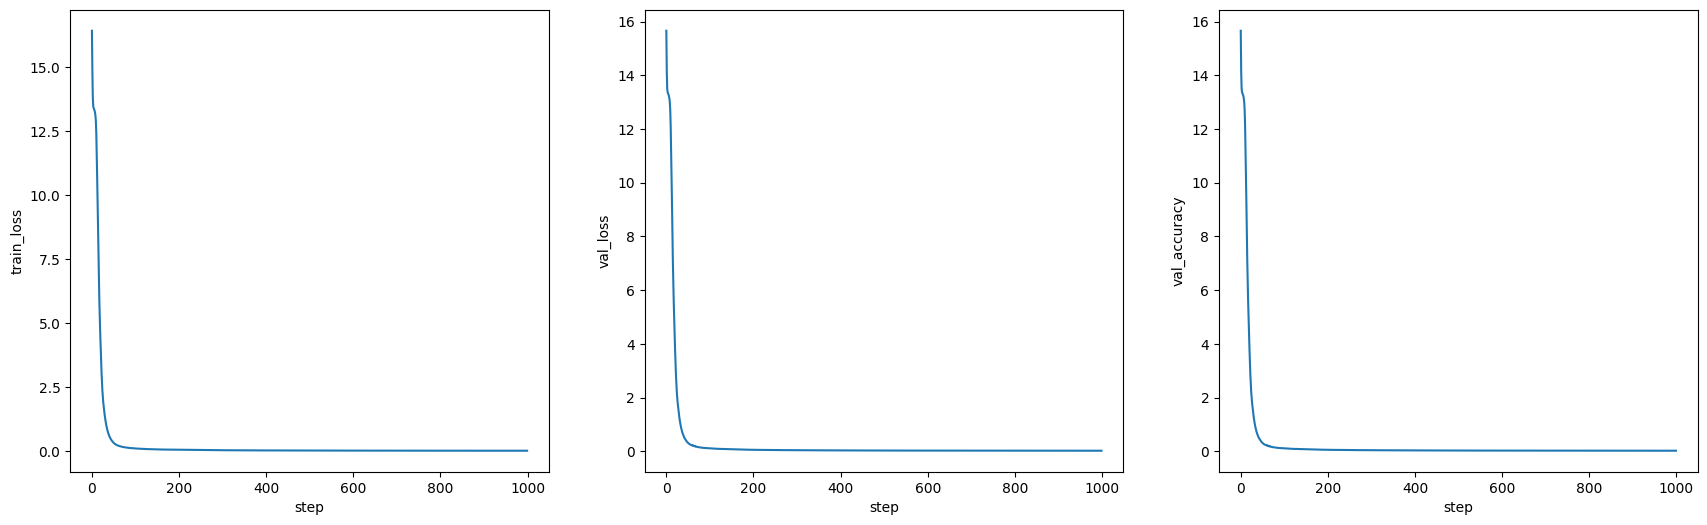

In [56]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot([int(i) for i in saves_loaded.keys()], [v['train_loss'] for v in saves_loaded.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot([int(i) for i in saves_loaded.keys()], [v['val_loss'] for v in saves_loaded.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot([int(i) for i in saves_loaded.keys()], [v['val_accuracy'] for v in saves_loaded.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

## Try on test data

In [24]:
data_test = pd.read_csv(fn_test_data)
try:
    data_test.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

filt = data_test['sample_name'] == data_test['sample_name'].unique()[0]

# Balance the dataset
df_test = drop_duplicates_keep_first_n(data_test[filt], get_true_interaction_cols(
    data_test, 'energies', remove_symmetrical=True), n=100)

x_test = [df_test[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x_test = np.concatenate(x_test, axis=input_concat_axis+1).squeeze()

y_test = x_test

if SCALE_X:
    x_test = xscaler.transform(x_test)
    y_test = xscaler.transform(y_test)

In [32]:
pred_y_test = model.apply(p, rng, x_test, call_kwargs={'inference': True, 'logging': False, 'key': rng})
pred_y_test.shape

(153600, 6)

The R2 score is  0.998098272926714
The R2 score with weighted variance is  0.998098272926714


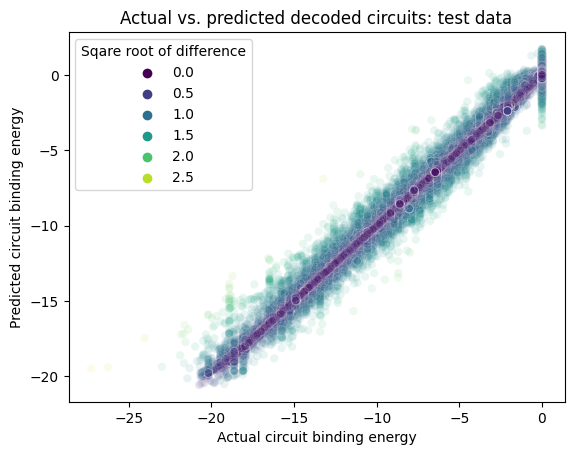

In [34]:
g = sns.scatterplot(x=y_test.flatten(), y=pred_y_test.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y_test.flatten() - y_test.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits: test data')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')
# plt.legend(title='')

print('The R2 score is ', r2_score(y_test.flatten(), pred_y_test.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y_test.flatten(), pred_y_test.flatten(), multioutput='variance_weighted'))

## Visualise network

In [35]:
import graphviz


model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, call_kwargs={'key': rng})
model = hk.transform(model_fn)
params2 = model.init(rng, x[:2])
dot = hk.experimental.to_dot(model_fn)(x)

graphviz.Source(dot)

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


ValueError: All `hk.Module`s must be initialized inside an `hk.transform`.

In [37]:
# print(hk.experimental.tabulate(model.apply)(x_val))
